In [1]:
# --- Standard library ---
import os
import sys

# --- Local imports ---
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))
from utils.download_data.h2f_download_functions import get_augmented_multires, get_multires
from utils.sersic_functions import sersic_profile
from utils.plot_functions import *
from joblib import Parallel, delayed


In [2]:
def augment_dataframe(data_frame, percentaje=0.01, n_jobs=-1):
    """
    Duplica filas de un DataFrame según el número de augmentaciones calculado
    con un perfil de Sérsic.
    """
    def compute_num_aug(row):
        sersic_img = sersic_profile(
            image_shape=(600, 600),
            x_center=299, y_center=299,
            Re_arcsec=row["rSerRadius"],
            b_over_a=row["rSerAb"],
            theta_deg=row["rSerPhi"],
            pixel_scale=0.25,
            Ie=1.0,
            n=4
        )
        n_pix = np.count_nonzero(sersic_img) * percentaje
        return int(np.ceil(n_pix))

    nums = Parallel(n_jobs=n_jobs)(
        delayed(compute_num_aug)(row) for _, row in data_frame.iterrows()
    )
    data_frame = data_frame.copy()
    data_frame["num_augmentations"] = nums

    data_frame_aug = data_frame.loc[
       data_frame.index.repeat(data_frame["num_augmentations"])
    ].reset_index(drop=True)

    return data_frame_aug

In [20]:
data = np.load("/home/acontreras/PRISM/data/SERSIC/X_train_autolabeling_pasquet_002_percent.npz")
data["pos"].shape

(366458, 2)

In [9]:
data = np.load("/home/acontreras/PRISM/data/SERSIC/X_train_autolabeling_delight_1_percent_1.npz")
data["pos"].shape

(268633, 2)

In [2]:
df = pd.read_csv("../data/SERSIC/df_pasquet_train.csv")
df.shape

(301096, 9)

In [24]:
df_aug = augment_dataframe(df, percentaje=0.0002)

In [25]:
df_aug.shape

(366458, 10)

In [ ]:
data = np.load("/home/acontreras/PRISM/data/SERSIC/X_train_pasquet2.npz")
imgs = data["imgs"]
mask = (imgs.sum((3,4))==0).all((1,2))

In [3]:
idx=1923
#idx=0
img = get_multires(df, idx, size=30, filters="i")


ConnectionError: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))

In [2]:
r = np.load("/home/acontreras/PRISM/resultados/autolabeling_redshift_rizy_ult/test_results.npz")
preds = r["mean_preds"].transpose(0, 2, 1)
zspec = r["original_target"]

soft = torch.nn.Softmax(dim=1)
probs = soft(torch.tensor(preds))
mid_point_z = (torch.linspace(0, 0.4, 181)[:-1] + torch.linspace(0, 0.4, 181)[1:]) / 2
mid_point_z = mid_point_z.view(1, 180, 1)      # [1, 180, 1]

zphot  = (probs*mid_point_z).sum(1).mean(1)

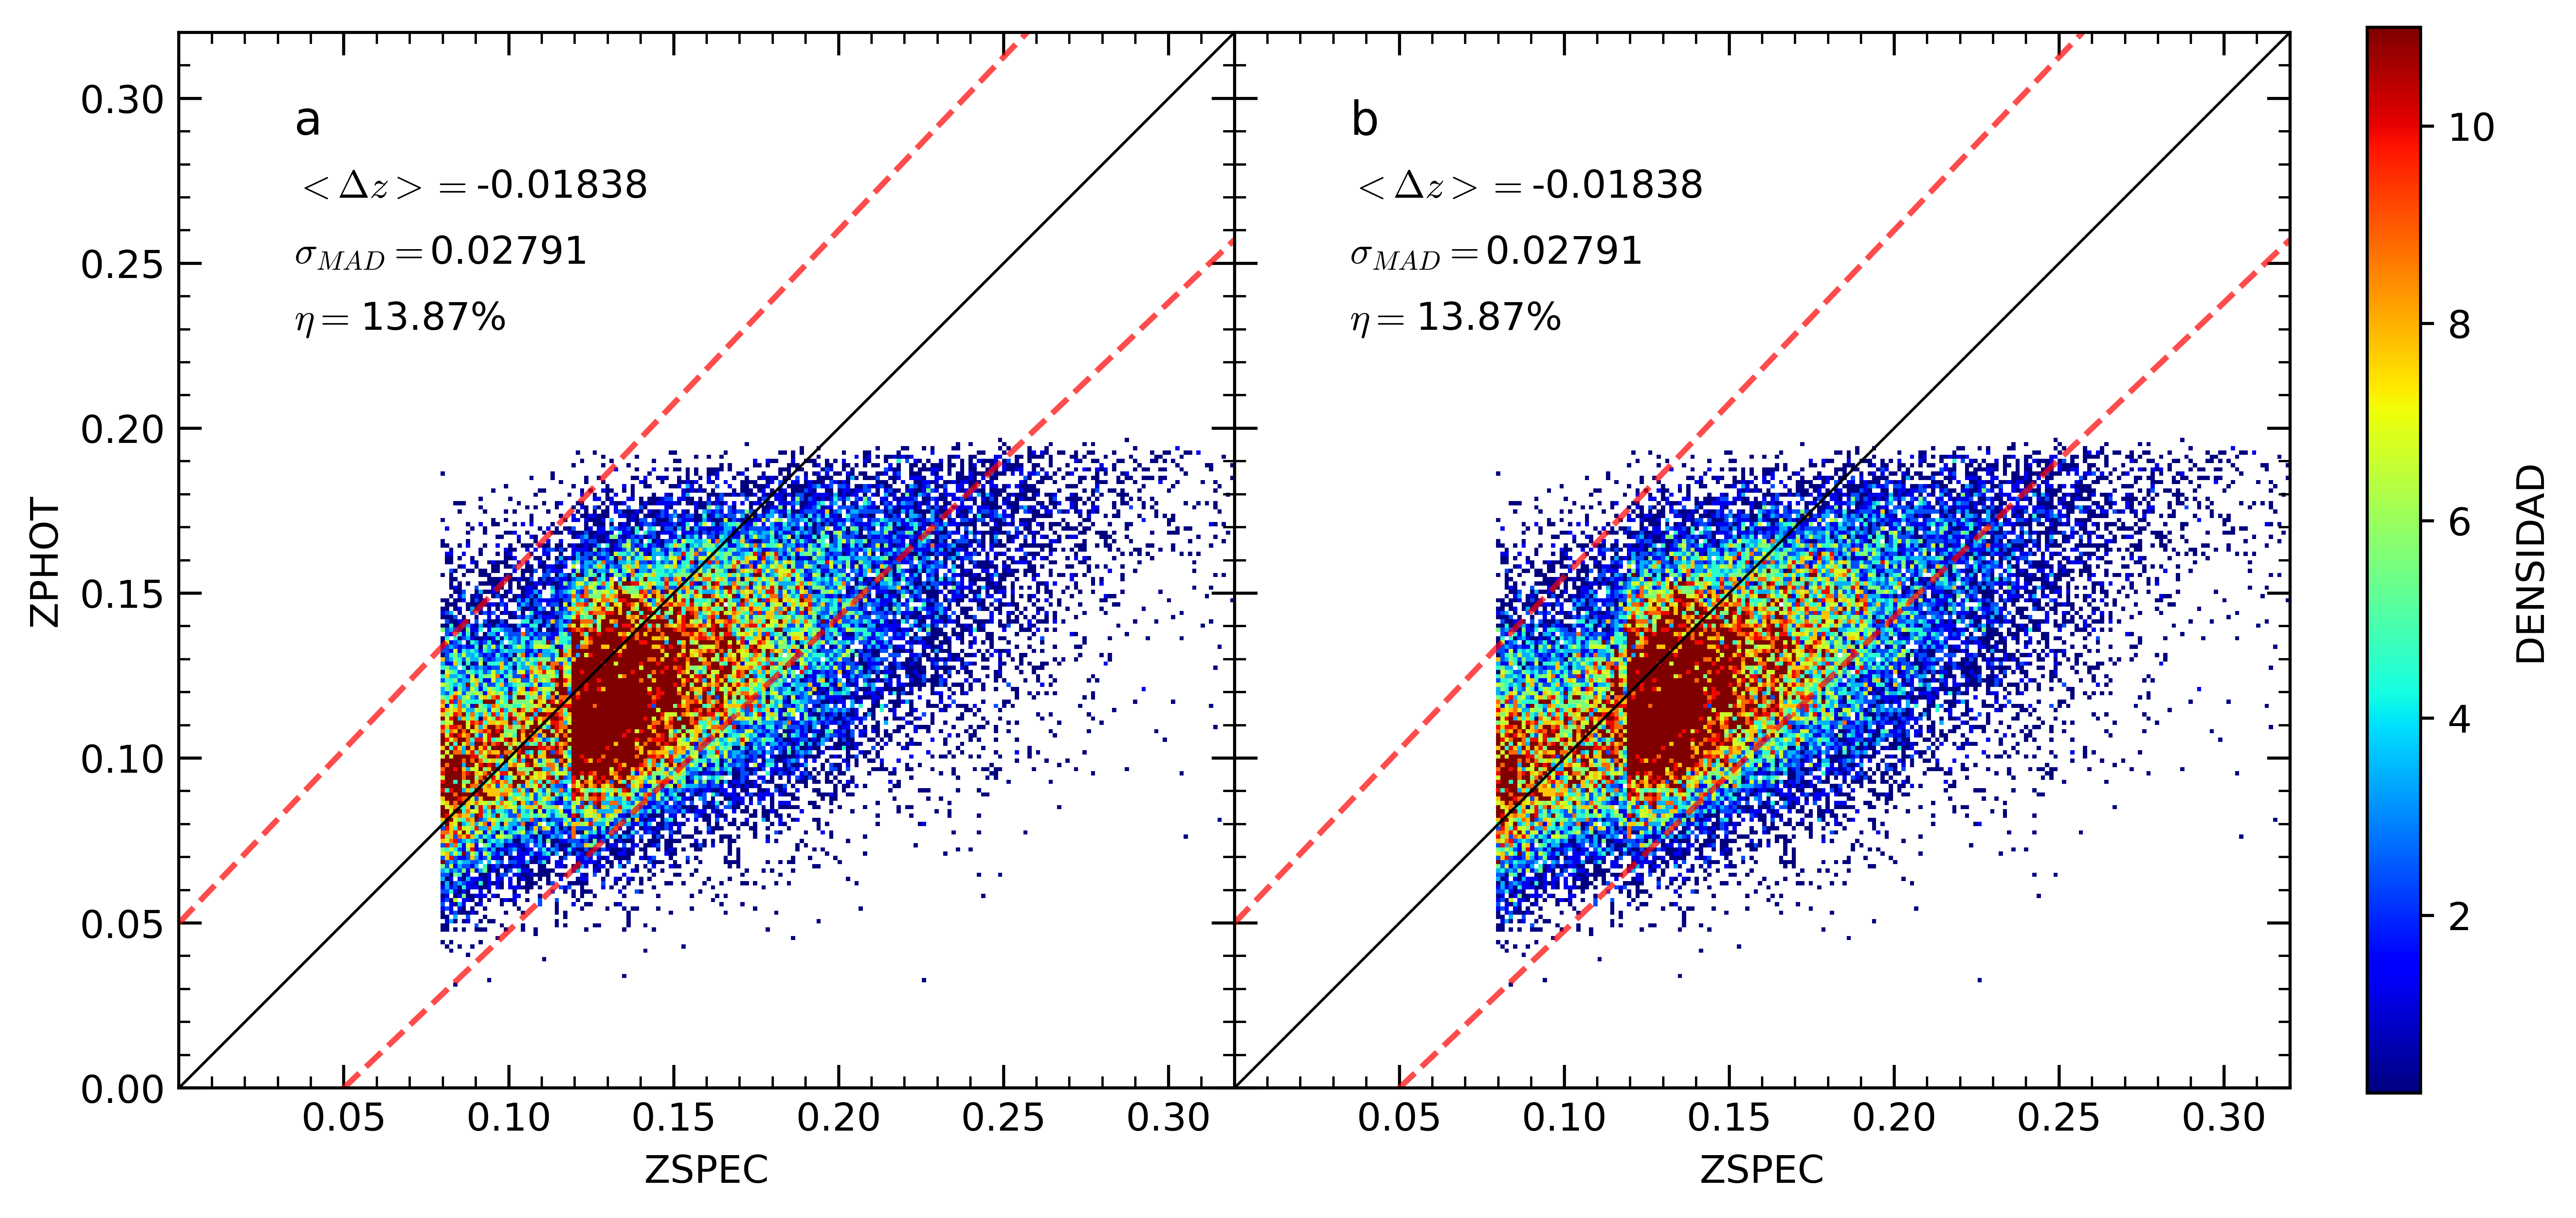

In [3]:
plot_regresion(zphot1 = zphot,
               zphot2 = zphot,
               zspec1 = zspec,
               zspec2 =zspec,
               name1= "a",name2="b",cmap = "jet",dpi=700)